# MURA, Abnormal X-ray Classification, Stanford

MURA is a dataset of bone X-rays that allows to create models that find abnormalities. 

## What is MURA?
MURA (**MU**sculoskeletal **RA**diographs) is a large dataset of bone X-rays that allows to create models that determines whether an X-ray study is normal or abnormal (we could use as well this dataset to classify bones into the categories shoulder, humerus, elbow, forearm, wrist, hand, and finger). MURA is one of the largest public radiographic image datasets.

https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Libraries 

In [0]:
import os 
import zipfile

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob

In [0]:
from fastai.vision import *
from fastai.widgets import *

from fastai.callbacks import *
import fastai

In [0]:
import torch 
import torchvision 

# for dataset 
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

# for model 
import torch.nn as nn
import torch.optim as optim

import shutil
import gc

print('Ver. Pytorch: ', torch.__version__)
print('CUDA: ', torch.cuda.is_available())

Ver. Pytorch:  1.3.1
CUDA:  True


## Data

### Download and Set a data path

In [0]:
!wget \
  htps://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip \
  -O /tmp/MURA.zip

--2020-01-03 02:25:48--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘/tmp/MURA.zip’

/tmp/MURA.zip       100%[===================>]   3.15G  14.9MB/s    in 3m 47s  

2020-01-03 02:29:36 (14.2 MB/s) - ‘/tmp/MURA.zip’ saved [3380245855/3380245855]



In [0]:
os.listdir('/tmp')

['drivefs_ipc.0', 'MURA.zip', 'drivefs_ipc.0_shell', 'tmpexmzd2ks']

In [0]:
local_zip = '/tmp/MURA.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
path = '/tmp/MURA-v1.1/'

In [0]:
os.listdir(path)

['valid',
 'valid_labeled_studies.csv',
 'train_labeled_studies.csv',
 'valid_image_paths.csv',
 'train',
 'train_image_paths.csv']

### Read csv files

In [0]:
df_train = pd.read_csv(path + 'train_image_paths.csv', header=None, names=['image'])
df_train.image[0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [0]:
df_valid = pd.read_csv(path + 'valid_image_paths.csv', header=None, names=['image'])
df_valid.image[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [0]:
df_train_label = pd.read_csv(path + 'train_labeled_studies.csv', header=None, names=['image', 'label'])
df_train_label.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [0]:
df_valid_label = pd.read_csv(path + 'valid_labeled_studies.csv', header=None, names=['image', 'label'])
df_valid_label.head()

,image,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


### Create folder 'data2' to train models

In [0]:
path_train = path + 'data2/train/'
path_valid = path + 'data2/valid/'

os.mkdir(path + 'data2/')
os.mkdir(path_train)
os.mkdir(path_valid)

In [0]:
os.mkdir(path_train + '0/')
os.mkdir(path_train + '1/')

path_train_neg = path_train + '0/'
path_train_pos = path_train + '1/'

In [0]:
os.mkdir(path_valid + '0/')
os.mkdir(path_valid + '1/')

path_valid_neg = path_valid + '0/'
path_valid_pos = path_valid + '1/'

In [0]:
print(path_train_neg)
print(path_train_pos)
print(path_valid_neg)
print(path_valid_pos)

/tmp/MURA-v1.1/data2/train/0/
/tmp/MURA-v1.1/data2/train/1/
/tmp/MURA-v1.1/data2/valid/0/
/tmp/MURA-v1.1/data2/valid/1/


### Get list of images

In [0]:
fnames_train = get_image_files(path + 'train', recurse=True)
print(len(fnames_train))
fnames_train[:5]

36808


[PosixPath('/tmp/MURA-v1.1/train/XR_ELBOW/patient05624/study1_negative/image1.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_ELBOW/patient05624/study1_negative/image2.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_ELBOW/patient05492/study1_negative/image1.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_ELBOW/patient05492/study1_negative/image2.png'),
 PosixPath('/tmp/MURA-v1.1/train/XR_ELBOW/patient05492/study1_negative/image4.png')]

In [0]:
fnames_valid = get_image_files(path + 'valid', recurse=True)
print(len(fnames_valid))
fnames_valid[:5]

3197


[PosixPath('/tmp/MURA-v1.1/valid/XR_ELBOW/patient11603/study1_positive/image1.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_ELBOW/patient11603/study1_positive/image2.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_ELBOW/patient11849/study1_negative/image1.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_ELBOW/patient11849/study1_negative/image2.png'),
 PosixPath('/tmp/MURA-v1.1/valid/XR_ELBOW/patient11466/study1_negative/image1.png')]

### Copy images into data2

In [0]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/[^/]+/[^/]+/([^/]+)/[^/]+.png$')
# pat_study_negpos = re.compile(r'\\[^\\]+\\[^\\]+\\study\d+_([^\\]+)\\[^\\]+.png$')

In [0]:
%%time
# copy all train images in corresponding class folders under MURA-v1.1/data2/train
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_train_neg
    else:
        path_label = path_train_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label + img_name
    shutil.copy(str(src), str(dest))

CPU times: user 2.67 s, sys: 5.19 s, total: 7.86 s
Wall time: 54.3 s


In [0]:
%%time
# copy all valid images in corresponding class folders under MURA-v1.1/data2/valid
for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_valid_neg
    else:
        path_label = path_valid_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label + img_name
    shutil.copy(str(src), str(dest))

CPU times: user 298 ms, sys: 648 ms, total: 946 ms
Wall time: 7.89 s


### Number of studies

In [0]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^/]+/[^/]+.png$')

In [0]:
mura = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

study_train_dict = dict()
study_valid_dict = dict()

for m in mura:
    study_train_dict[m] = list()
    study_valid_dict[m] = list()
    
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_train_dict[label.lower()].append(s)

for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_valid_dict[label.lower()].append(s)

In [0]:
num_train_studies = 0
num_valid_studies = 0

for m in mura:
    # train
    myset = set(study_train_dict[m])
    num_train_studies += len(myset)
    # valid
    myset = set(study_valid_dict[m])
    num_valid_studies += len(myset)

In [0]:
# 207 studies in test
num_train_studies, num_valid_studies, num_train_studies + num_valid_studies + 207

(13457, 1199, 14863)

## Training with Resnet34

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
epochs = 5
batch_size = 1

In [0]:
# 01 transforms
means = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize(means, std)])
test_transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize(means, std)])

In [0]:
trainset = torchvision.datasets.ImageFolder(root=path_train, transform=train_transform)
testset = torchvision.datasets.ImageFolder(root=path_valid, transform=test_transform)

In [0]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
print(len(trainset))
print(len(testset))

36808
3197


In [0]:
print(trainloader.dataset)
print(testloader.dataset)

Dataset ImageFolder
    Number of datapoints: 36808
    Root location: /tmp/MURA-v1.1/data2/train/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset ImageFolder
    Number of datapoints: 3197
    Root location: /tmp/MURA-v1.1/data2/valid/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [0]:
classes = trainloader.dataset.classes
classes

['0', '1']

In [0]:
model = models.resnet34()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
in_fc = model.fc.in_features
out_fc = len(classes)
print(in_fc)
print(out_fc)

512
2


In [0]:
model.fc = nn.Linear(in_fc, out_fc)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
model = model.to(device)

In [0]:
a = torch.rand(1, 3, 224, 224).to(device)
out = model(a)
print(out.shape)
print(out)

torch.Size([1, 2])
tensor([[-0.6048, -0.2401]], device='cuda:0', grad_fn=<AddmmBackward>)


In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-6)

In [0]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://c31a5291.ngrok.io


In [0]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            
    return loss.item()

In [0]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)

          # 배치 오차를 합산
          test_loss += criterion(output, target).item()

          # 가장 높은 값을 가진 인덱스가 바로 예측값
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [0]:
hist_epoch =[]
hist_train_loss = []
hist_test_loss = []
hist_test_acc = []
globaliter = 0
for epoch in range(1, epochs + 1):
  globaliter += 1
  loss = train(model, trainloader, optimizer, epoch)
  test_loss, test_accuracy = evaluate(model, testloader)
    
  hist_epoch.append(epoch)
  hist_train_loss.append(loss)
  hist_test_loss.append(test_loss)
  hist_test_acc.append(test_accuracy)

# tb.save_value('Train Loss', 'train_loss', 'test_loss', 'test_acc', globaliter, loss, test_loss, test_accuracy)
  tb.save_value('MURA_Loss',  'train_loss', globaliter, loss)
  tb.save_value('MURA_Loss',  'test_loss', globaliter, test_loss)
  tb.save_value('MURA_Acc',  'test_acc', globaliter, test_accuracy)

  print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/36808 (0%)]	Loss: 0.731780
Train Epoch: 1 [500/36808 (1%)]	Loss: 0.565671
Train Epoch: 1 [1000/36808 (3%)]	Loss: 0.852813
Train Epoch: 1 [1500/36808 (4%)]	Loss: 0.763729
Train Epoch: 1 [2000/36808 (5%)]	Loss: 1.328415
Train Epoch: 1 [2500/36808 (7%)]	Loss: 0.514471
Train Epoch: 1 [3000/36808 (8%)]	Loss: 0.445304
Train Epoch: 1 [3500/36808 (10%)]	Loss: 0.822124
Train Epoch: 1 [4000/36808 (11%)]	Loss: 0.197726
Train Epoch: 1 [4500/36808 (12%)]	Loss: 0.211529
Train Epoch: 1 [5000/36808 (14%)]	Loss: 0.315022
Train Epoch: 1 [5500/36808 (15%)]	Loss: 0.421705
Train Epoch: 1 [6000/36808 (16%)]	Loss: 0.399218
Train Epoch: 1 [6500/36808 (18%)]	Loss: 0.849028
Train Epoch: 1 [7000/36808 (19%)]	Loss: 0.543710
Train Epoch: 1 [7500/36808 (20%)]	Loss: 0.217937
Train Epoch: 1 [8000/36808 (22%)]	Loss: 0.837272
Train Epoch: 1 [8500/36808 (23%)]	Loss: 1.246378
Train Epoch: 1 [9000/36808 (24%)]	Loss: 1.159759
Train Epoch: 1 [9500/36808 (26%)]	Loss: 0.510396
Train Epoch: 1 [10000/36808 (27

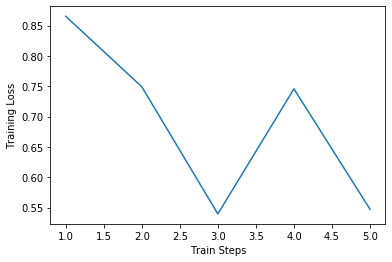

In [0]:
plt.plot(hist_epoch, hist_train_loss )
plt.xlabel('Train Steps')
plt.ylabel('Training Loss')
plt.show()

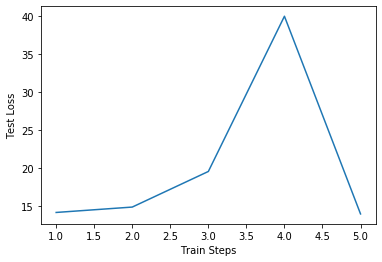

In [0]:
plt.plot(hist_epoch, hist_test_loss )
plt.xlabel('Train Steps')
plt.ylabel('Test Loss')
plt.show()

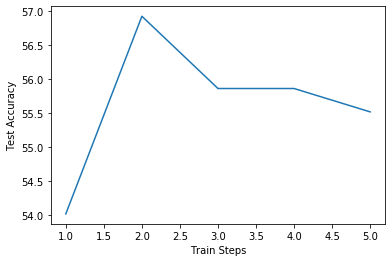

In [0]:
plt.plot(hist_epoch, hist_test_acc)
plt.xlabel('Train Steps')
plt.ylabel('Test Accuracy')
plt.show()